# Redes Neurais com Keras

## Configuração do notebook

Primeiro, vamos importar as bibliotecas a serem usadas no notebook.

In [24]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.neighbors import NearestNeighbors
import numpy as np

import tensorflow as tf
from tensorflow import keras

As funções a seguir serão auxiliares.

In [25]:
def plotimages(imgs, n_row=1, n_col=5, cmap='gray', titles = None):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 6))
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
    plt.show()

## Conjunto de dados

### Visualização dos dados

Como base de dados, vamos usar a coleção **fashion_mnist**, fornecida com o tensorflow:

In [26]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Observe que temos um conjunto de treino e um conjunto de teste. Cada um possui 60 mil e 10 mil imagens, respectivamente. 

As 60 mil imagens de roupas estão em 28x28 pixels.  
Cada pixel é um ponto de escala de cinza com 8 bits.

In [27]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

Vamos criar um array para mostrar os nomes das classes:

In [28]:
class_names = ["Camisetas/tops", "Calças", "Pulôver", "Vestido", "Casaco",
               "Sandália", "Camisa", "Tênis", "Bolsa", "Meia bota"]

Vamos selecionar aleatoriamente um exemplo de cada classe para observá-los.

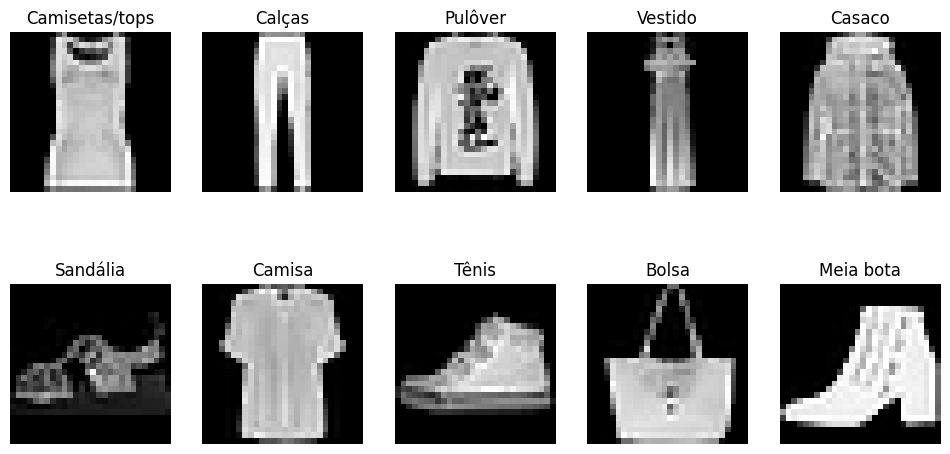

In [29]:
sample = [X_train_full[y_train_full==c][np.random.randint(0,100)] for c in range(len(class_names))]
plotimages(sample, n_row=2, titles = class_names)

### Separação dos dados e normalização

Vamos separar:

- Um conjunto de validação contendo as 5 mil primeiras imagens
- Um conjunto de treino contendo as 55 mil imagens restantes

Não vamos montar um conjunto de teste, pois a base trouxe um conjunto de teste quando carregamos os dados.

In [30]:
X_valid = X_train_full[:5000]
X_train = X_train_full[5000:]

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Agora vamos normalizar as imagens. Usaremos z-normalização, mas vamos fazer isso sem ajuda do **sklearn**.

In [31]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_valid = (X_valid - X_train.mean()) / X_train.std()

## Rede neural

Vamos montar uma rede neural com Keras. Nossa rede será profunda. Considere que uma rede neural é "profunda" se possui mais de uma camada oculta.

Podemos explorar diferentes configurações e diferentes funções de ativação. Porém, vamos fazer o "tradicional" primeiro:

- As camadas **ocultas** usarão função de ativação **ReLU**
- A camada **final** usará função de ativação **softmax**
- A **primeira** camada será **maior**, com 300 neurônios
- Cada camada **seguinte** terá uma quantidade cada vez mais **reduzida** de neurônios
- A **última** camada terá **10 neurônios** (um para cada classe)

### Tipos de montagem de rede

O Keras possui três estilos de descrição de uma rede neural:

- **Sequencial**, na qual cada camada é adicionada ao final da rede com **Sequential.add()**
- **Funcional**, na qual cada camada é criada e recebe como entrada a camada anterior
- **Orientado a objetos (sub-classing)**, na qual a rede neural inteira é uma classe que estende (herda de) a classe **models.Model**.

#### O modelo sequencial

Começamos instanciando um objeto da classe **keras.model.Sequential**.

In [32]:
model_seq = keras.models.Sequential()

Como os dados são imagens, para que eles possam ser processados por uma rede neural densa eles precisam primeiramente ser concatenados em um vetor:

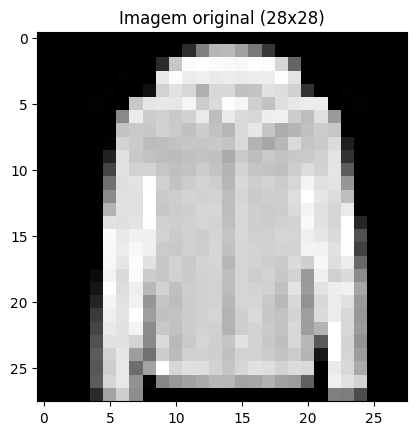

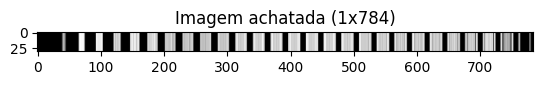

In [33]:
imagem = X_train[0]

plt.figure();
plt.title('Imagem original (28x28)')
plt.imshow(imagem, cmap='gray')
plt.show()

plt.figure();
plt.title('Imagem achatada (1x784)')
imagem_flat = imagem.ravel()
plt.imshow(np.ones([30,1]) * imagem_flat, cmap='gray');
plt.show();

A camada de entrada será um objeto da classe **keras.layers.Flatten**.  
Uma "camada **flatten** (ou, em uma tradução literal pouco comum, "camada de achatamento") recebe como entrada um tensor de alta dimensão e contatena-o em um vetor.

In [34]:
model_seq.add(keras.layers.Flatten(input_shape=[28, 28]))

As camadas ocultas serão camadas densas. Começaremos com 300 e vamos reduzindo os tamanhos dessas camadas.

Isso tem os seguintes efeitos:

- Cada camada funciona como um extrator de características. Os dados começam com os atributos "brutos" e vão se tornando cada vez mais abstratos
- Cada camada vai reduzindo a dimensionalidade dos dados, mantenado as características mais importantes à medida que avança


In [35]:
model_seq.add(keras.layers.Dense(300, activation="relu"))
model_seq.add(keras.layers.Dense(150, activation="relu"))
model_seq.add(keras.layers.Dense(100, activation="relu"))
model_seq.add(keras.layers.Dense(50, activation="relu"))

Ao final, teremos uma camada com 10 neurônios e função de ativação **softmax**.

- São 10 neurônios porque temos 10 classes
- A função de ativação **softmax** converte as saídas dos neurônios em probabilidades
- O neurônio correspondente à classe mais provável terá maior valor de saída
- A soma de todas as saídas será sempre 1

In [36]:
model_seq.add(keras.layers.Dense(10, activation="softmax"))

O método `summary` gera um resumo da descrição da rede.

In [37]:
model_seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,310 (1.15 MB)

 Trainable params: 301,310 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Agora basta compilar e treinar.

Mas, antes, vamos comparar com as outras duas formas de construir modelos.

#### O modelo funcional

No modelo funcional, cada camada é criada com uma chamada de função que recebe a camada anterior como parâmetro.  
Normalmente, especificamos uma variável para a camada de entrada (no exemplo abaixo, **model_input**) e uma variável para a camada de saída (abaixo, **yhat**, simbolizando o estimador da classe $\hat{y}$).  
Para as demais camadas, nós reutilizamos uma variável de "nome genérico".

In [38]:
model_input = keras.layers.Input(shape=(28, 28), name="images")

X = keras.layers.Flatten(name="input")(model_input)
X = keras.layers.Dense(300, activation="relu", name="h1")(X)
X = keras.layers.Dense(150, activation="relu", name="h2")(X)
X = keras.layers.Dense(100, activation="relu", name="h3")(X)
X = keras.layers.Dense(50, activation="relu", name="h4")(X)

yhat = keras.layers.Dense(10, activation="softmax", name="output")(X)

model_func = keras.models.Model(inputs=[model_input], outputs=[yhat])

In [39]:
model_func.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ images (InputLayer)             │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input (Flatten)                 │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h1 (Dense)                      │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h3 (Dense)                      │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h4 (Dense)                      │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,310 (1.15 MB)

 Trainable params: 301,310 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

O modelo funcional é mais genérico e nos permite fazer arquiteturas que não são sequenciais.  
Podemos ter camadas paralelas e conexões de uma camada diretamente com camadas mais a frente.  
Além disso, no modelo funcional, nós podemos ter mais de um caminho de entrada e mais de um caminho de saída.

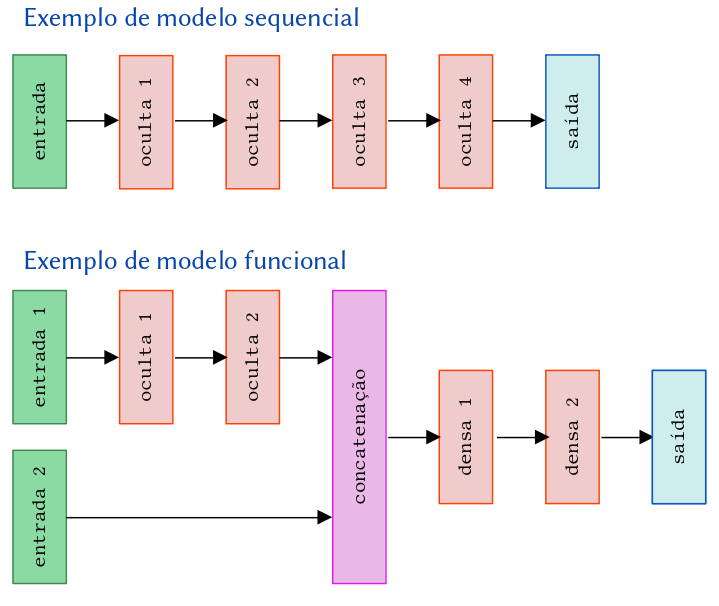

#### O modelo orientado a objetos

Também podemos construir a rede neural criando uma classe específica para isso.  
A nossa classe tem que estender (herdar de) a classe **keras.models.Model**. Portanto, o modelo orientado a objetos é uma extensão do modelo funcional.  
Nós fazemos isso quando queremos encapsular a rede neural em uma classe própria e manipular mais detalhadamente a classe do modelo do Keras.

In [41]:
# Um modelo com subclassing
class SubclassingModel(keras.models.Model):
    def __init__(self, **kwargs):
        # Chamando o construtor
        super(SubclassingModel, self).__init__(**kwargs)
        # Inicializando as camadas
        self.input_layer = keras.layers.Flatten(name="input_layer")
        self.h1 = keras.layers.Dense(300, activation="relu", name="h1")
        self.h2 = keras.layers.Dense(150, activation="relu", name="h2")
        self.h3 = keras.layers.Dense(100, activation="relu", name="h3")
        self.h4 = keras.layers.Dense(50, activation="relu", name="h4")
        self.out_layer = keras.layers.Dense(10, activation="softmax", name="out_layer")

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.out_layer(x)
        return x

model_oop = SubclassingModel()

## Montagem e treinamento da rede neural

Vamos construir a seguinte arquitetura:

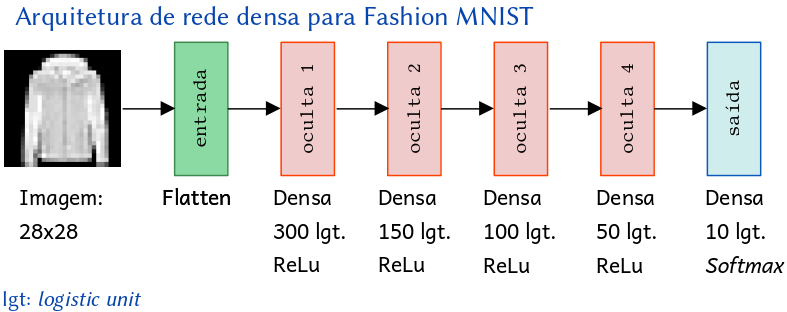

Vamos usar o modelo sequencial para montar essa arquitura, já que ela é bem linear.

In [42]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28], name='entrada'))

model.add(keras.layers.Dense(300, activation="relu", name='oculta_1'))
model.add(keras.layers.Dense(150, activation="relu", name='oculta_2'))
model.add(keras.layers.Dense(100, activation="relu", name='oculta_3'))
model.add(keras.layers.Dense(50, activation="relu", name='oculta_4'))

model.add(keras.layers.Dense(10, activation="softmax", name='saida'))

/home/mariasales/ml/.venv/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Após a especificação da arquitetura, precisamos **compilar** o modelo. Algumas questões importantes:

- **loss**: a função de custo. Como se trata de um problema de classificação multiclasse, o ideal é usar a entropia cruzada categórica esparsa
- **otimizador**: vamos manter o Adam
- **metrics**: qualquer métrica que queiramos acompanhar durante o treinamento, além da função de custo. Vamos acompanhar apenas a acurácia.

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

O próximo passo é treinar. Vamos treinar por apenas 10 épocas e manter um mini-lote de tamanho 100.

O conjunto de validação será aquele separado anteriormente.

In [44]:
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8246 - loss: 0.4777 - val_accuracy: 0.7572 - val_loss: 32.2538
Epoch 2/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8702 - loss: 0.3505 - val_accuracy: 0.7948 - val_loss: 24.4432
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8825 - loss: 0.3173 - val_accuracy: 0.8004 - val_loss: 24.6200
Epoch 4/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8901 - loss: 0.2924 - val_accuracy: 0.7844 - val_loss: 26.5242
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8973 - loss: 0.2729 - val_accuracy: 0.7758 - val_loss: 32.3330
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9030 - loss: 0.2586 - val_accuracy: 0.8018 - val_loss: 24.3938
Epoch 7/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9082 - loss: 0.2439 - val_accuracy: 0.7888 - val_loss: 27.6798
Epoch 8/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9129 - loss: 0.2318 - val_accur

Vamos entender o que acontece por trás: 

1. Forward Pass
- O computador passa o batch de 100 imagens pela rede.
- A rede faz cálculos de acordo com a configuração atual dos 300.000 parâmetros e dá 100 palpites - um para cada exemplo. 

2. Cálculo do erro (Loss)
- O computador compara os palpites com as respostas reais.
- Calcula o valor de Loss (o quanto errou).

3. Backpropagation
- O algoritmo anda de trás para frente vendo o que precisa ajustar de direção e intensidade nos 300.000 parâmetros.

4. Ajuste (Optimizer Step)
- Ajusta os parâmetros.
- Isso conta como 1 atualização da rede.
- Fisicamente, 300.000 números foram alterados na memória RAM.



Podemos ver quantos ajustes foram feitos no total:

Em 1 época, ajustamos 300.000 parâmetros 500 vezes.  
Isso dá: 
$$300.000 \times 550 = 165.000.000 \text{ ajustes}$$

Em 10 épocas, temos: 
$$165.000.000 \times 10 = 1.650.000.000 \text{ ajustes}$$



In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_1 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_2 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_3 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta_4 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 903,932 (3.45 MB)

 Trainable params: 301,310 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 602,622 (2.30 MB)

Note que o log do treino guarda informação sobre todas as métricas avaliadas ao longo das épocas, como um dicionário Python:

In [ ]:
history.history

Então podemos plotar esses números para observar a evolução do treinamento.



In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, 'b', label='Treino')
plt.plot(val_loss, 'r', label='Validação')
plt.title('Evolução do custo durante o treinamento')
plt.grid()
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(acc, 'b', label='Treino')
plt.plot(val_acc, 'r', label='Validação')
plt.title('Evolução da acurácia durante o treinamento')
plt.grid()
plt.legend();

Para avaliar o modelo, podemos usar evalute:

In [ ]:
model.evaluate(X_test, y_test)

O resultado pode variar com a execução, mas você provavelmente observará que ocorreu *overfitting*. O modelo parece ser complexo demais para os dados da Fashion MNIST.

## Rede neural como extrator de características

A grande vantagem de uma rede neural profunda é que ela funciona como um extrator de características. Conforme os dados vão "avançando" pela rede, as características vão se tornando cada vez mais abstratas e em menor quantidade.

Isso é ilustrado pela figura a seguir.

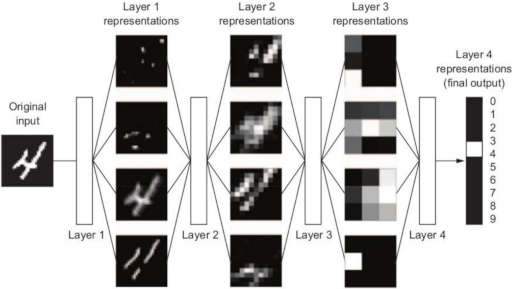

### Acessando uma camada específica da rede

O modelo treinado nos permite visualizar as camadas da rede.

In [ ]:
model.summary()

In [ ]:
model.layers

A segunda camada oculta:

In [ ]:
model.layers[2]

Note que essa camada possui um nome (que nós escolhemos quando instanciamos as camadas):

In [ ]:
model.layers[2].name

E ela pode ser recuperada pelo seu nome

In [ ]:
model.get_layer('oculta_2')

### Visualização do codificador

Podemos tirar proveito dessa propriedade de extração de características e transformar a rede neural em um legítimo codificador.

Não devemos retreinar a rede. Em vez disso, precisamos criar um novo modelo usando as camadas anteriormente treinadas, mas especificando a última camada densa como a nova camada de saída.

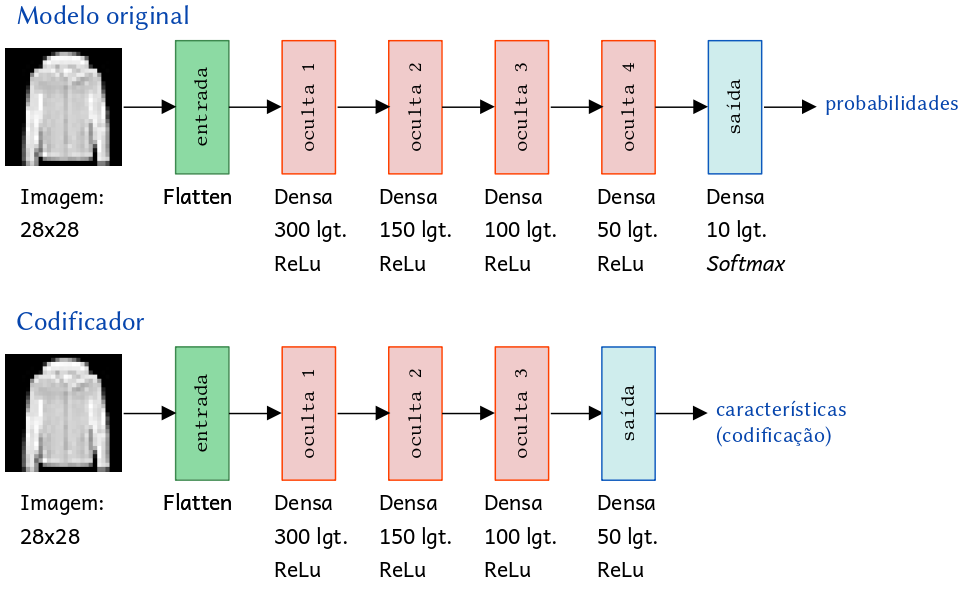

Vamos especificar um novo modelo:

- A entrada será a mesma entrada do modelo original
- A saída desse modelo será a saída da última camada oculta do modelo original (ela preserva seu nome de "camada oculta", embora não seja mais oculta)

In [ ]:
codificador = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('oculta_4').output)

In [ ]:
codificador.summary()

Podemos até visualizar essas características para um exemplo qualquer:

In [ ]:
codificador.predict(np.array([X_test[0]]))

Se redes neurais modificam o espaço de forma que cada camada facilita a separação linear das classes, é de se esperar que as representações de duas entradas da mesma classe, em uma camada profunda de uma rede neural, sejam similares.

Em outras palavras, se codificarmos todos os exemplos nesse espaço de 50 características, epseraremos que os vizinhos mais próximos sejam (em sua maioria) da mesma classe.

De certa forma, é como se a codificação dessas entradas ganhassem uma natureza conceitual.

Vamos começar codificando todo o conjunto de teste em uma matriz de características extraídas.

In [ ]:
Xt_codes = codificador.predict(X_test)

In [ ]:
Xt_codes.shape

Vamos agora armazenar estes pontos de forma a podermos recuperá-los de acordo com suas distâncias. Para isso, basta "treinar" um k-NN com esses dados. Vamos usar para isso uma kd-tree, que é uma estrutura de índices eficiente para encontrar vizinhos mais próximos em um espaço de alta dimensão.

In [ ]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')
nbrs.fit(Xt_codes);

Se tomarmos um ponto aleatório entre os 1000 de testes e procurarmos seus 10 vizinhos mais próximos, observamos o seguinte:

In [ ]:
r = np.random.randint(0, Xt_codes.shape[0], 1)[0]
_, indices = nbrs.kneighbors(Xt_codes[r].reshape(1,-1))
plotimages([X_test[r] for r in indices[0]], n_row = 2, n_col = 5)

O que confirma a ideia de que as representações de imagens semelhantes são semelhantes, ou seja, o espaço está "organizado" de forma que objetos semelhantes ocorrem perto uns dos outros!